## Проверка работы системы сплитования пользователей

Есть данные АА-теста с '2022-12-25' по '2022-12-31'. Убедимся в том, что система сплитования работает корректно, и ключевая метрика не отличается между группами не только в конкретно нашем АА-тесте, но и в целом. Сделаем симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации сформируем подвыборки без повторения в 500 пользователей из 2 и 3 экспериментальной группы. Проведём сравнение этих подвыборок t-testом.

1. Подключаемся к базе данных

In [1]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230120',
                      'user':'student', 
                      'password':'dpo_python_2020'
             }

2. Импортируем нужные библиотеки

In [2]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

3. Формируем общий dataframe и передаём переменным строки, соответствуюшие группе пользователей

In [3]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') AS likes,
    sum(action = 'view') AS views,
    likes/views AS ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2022-12-25' AND '2022-12-31'
  AND exp_group IN (2, 3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

group_A = df[df.exp_group == 2].copy()
group_B = df[df.exp_group == 3].copy()

In [4]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


4. Выбираем из групп А и В по 500 значений, применяем t-тест к этим группам и записываем результат в список. 
Повторяем 10000 раз и строим график распределения p-value.

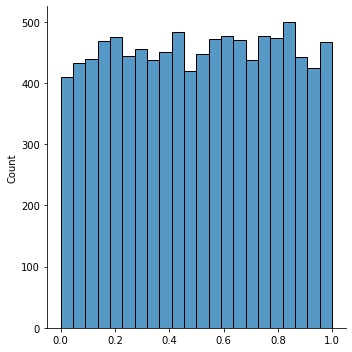

In [5]:
p_list = []
for _ in range(10000):
    p_value = stats.ttest_ind(group_A.ctr.sample(500, replace=False), 
                              group_B.ctr.sample(500, replace=False), 
                              equal_var=False)
    p_list.append(p_value.pvalue)
sns.displot(p_list)

5. Посчитаем, какой процент p-values оказался меньше или равен 0.05.

In [6]:
sum(np.array(p_list) < 0.05) / 10000 * 100

4.49

### Вывод

Судя по графику, распределение p-values похоже на равномерное. Процент p-values, который меньше или равен 0.05, меньше 5. 
Статистически значимые различия между 2 и 3 группой проявляются только в ~4.49 % случаев.
Следовательно, статистически значимой разницы между группами нет, и система сплитования работает корректно